In [90]:
!pip install sentence-transformers
!pip install pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [91]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [92]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [93]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [94]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [95]:
data = data.dropna()

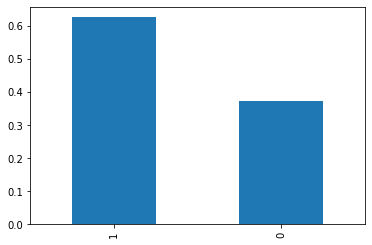

In [96]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [97]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [98]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [99]:
len(train_data)*1, type(train_labels), train_labels.shape


(3208, numpy.ndarray, (3208,))

In [100]:
train_data = train_data.iloc[0:3208]
train_labels = train_labels[0:3208]

In [101]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 3208, 3208)

In [102]:

def random_deletion(sentence, p=0.2): 
  words = sentence.split()
  if len(words) <= 3:
    return ' '.join(words)
  remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
  if len(remaining) == 0: # if not left, sample a random word
    return ' '.join([random.choice(words)])
  else:
    return ' '.join(remaining)


In [103]:
random_deletion("Hi i am ")

'Hi i am'

In [104]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_deletion(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [105]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [106]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [107]:
len(test_examples)

802

In [108]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  1675


In [109]:
len(train_examples)

4883

In [110]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [111]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [112]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:53:50 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 19:53:50 - Use pytorch device: cuda
2022-09-07 19:53:50 - Softmax loss: #Vectors concatenated: 3
306


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:54:15 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:54:16 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.4603)
2022-09-07 19:54:16 - F1 with Cosine-Similarity:                 84.59	(Threshold: 0.3280)
2022-09-07 19:54:16 - Precision with Cosine-Similarity:          76.61
2022-09-07 19:54:16 - Recall with Cosine-Similarity:             94.43
2022-09-07 19:54:16 - Average Precision with Cosine-Similarity:  90.92

2022-09-07 19:54:16 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 362.7212)
2022-09-07 19:54:16 - F1 with Manhattan-Distance:                 84.44	(Threshold: 366.0925)
2022-09-07 19:54:16 - Precision with Manhattan-Distance:          80.76
2022-09-07 19:54:16 - Recall with Manhattan-Distance:             88.47
2022-09-07 19:54:16 - Average Precision with Manhattan-Distance:  91.00

2022-09-07 19:54:16 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 16.5225)
2022-09-07 19:54:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:54:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:54:41 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.3004)
2022-09-07 19:54:41 - F1 with Cosine-Similarity:                 86.32	(Threshold: 0.3004)
2022-09-07 19:54:41 - Precision with Cosine-Similarity:          80.20
2022-09-07 19:54:41 - Recall with Cosine-Similarity:             93.44
2022-09-07 19:54:41 - Average Precision with Cosine-Similarity:  91.60

2022-09-07 19:54:41 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 415.7628)
2022-09-07 19:54:41 - F1 with Manhattan-Distance:                 86.31	(Threshold: 427.1168)
2022-09-07 19:54:41 - Precision with Manhattan-Distance:          79.33
2022-09-07 19:54:41 - Recall with Manhattan-Distance:             94.63
2022-09-07 19:54:41 - Average Precision with Manhattan-Distance:  91.77

2022-09-07 19:54:41 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 19.3214)
2022-09-07 19:54:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:55:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:55:07 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.4214)
2022-09-07 19:55:07 - F1 with Cosine-Similarity:                 86.64	(Threshold: 0.3241)
2022-09-07 19:55:07 - Precision with Cosine-Similarity:          81.22
2022-09-07 19:55:07 - Recall with Cosine-Similarity:             92.84
2022-09-07 19:55:07 - Average Precision with Cosine-Similarity:  91.67

2022-09-07 19:55:07 - Accuracy with Manhattan-Distance:           82.04	(Threshold: 414.7073)
2022-09-07 19:55:07 - F1 with Manhattan-Distance:                 86.64	(Threshold: 416.4011)
2022-09-07 19:55:07 - Precision with Manhattan-Distance:          81.22
2022-09-07 19:55:07 - Recall with Manhattan-Distance:             92.84
2022-09-07 19:55:07 - Average Precision with Manhattan-Distance:  91.72

2022-09-07 19:55:07 - Accuracy with Euclidean-Distance:           82.29	(Threshold: 17.5584)
2022-09-07 19:55:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:55:31 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:55:32 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.3404)
2022-09-07 19:55:32 - F1 with Cosine-Similarity:                 85.03	(Threshold: 0.2747)
2022-09-07 19:55:32 - Precision with Cosine-Similarity:          81.68
2022-09-07 19:55:32 - Recall with Cosine-Similarity:             88.67
2022-09-07 19:55:32 - Average Precision with Cosine-Similarity:  91.27

2022-09-07 19:55:32 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 427.0103)
2022-09-07 19:55:32 - F1 with Manhattan-Distance:                 84.92	(Threshold: 427.0103)
2022-09-07 19:55:32 - Precision with Manhattan-Distance:          81.65
2022-09-07 19:55:32 - Recall with Manhattan-Distance:             88.47
2022-09-07 19:55:32 - Average Precision with Manhattan-Distance:  91.43

2022-09-07 19:55:32 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 18.9568)
2022-09-07 19:55:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:55:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:55:57 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.2812)
2022-09-07 19:55:57 - F1 with Cosine-Similarity:                 85.42	(Threshold: 0.2013)
2022-09-07 19:55:57 - Precision with Cosine-Similarity:          81.56
2022-09-07 19:55:57 - Recall with Cosine-Similarity:             89.66
2022-09-07 19:55:57 - Average Precision with Cosine-Similarity:  91.11

2022-09-07 19:55:57 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 416.8217)
2022-09-07 19:55:57 - F1 with Manhattan-Distance:                 85.26	(Threshold: 467.3687)
2022-09-07 19:55:57 - Precision with Manhattan-Distance:          80.78
2022-09-07 19:55:57 - Recall with Manhattan-Distance:             90.26
2022-09-07 19:55:57 - Average Precision with Manhattan-Distance:  91.21

2022-09-07 19:55:57 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 18.8353)
2022-09-07 19:55:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:56:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:56:22 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.2873)
2022-09-07 19:56:22 - F1 with Cosine-Similarity:                 85.74	(Threshold: -0.0372)
2022-09-07 19:56:22 - Precision with Cosine-Similarity:          78.93
2022-09-07 19:56:22 - Recall with Cosine-Similarity:             93.84
2022-09-07 19:56:22 - Average Precision with Cosine-Similarity:  91.18

2022-09-07 19:56:22 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 400.8601)
2022-09-07 19:56:22 - F1 with Manhattan-Distance:                 85.82	(Threshold: 521.3687)
2022-09-07 19:56:22 - Precision with Manhattan-Distance:          79.06
2022-09-07 19:56:22 - Recall with Manhattan-Distance:             93.84
2022-09-07 19:56:22 - Average Precision with Manhattan-Distance:  91.23

2022-09-07 19:56:22 - Accuracy with Euclidean-Distance:           81.30	(Threshold: 18.1695)
2022-09-07 19:56

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:56:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:56:47 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.2654)
2022-09-07 19:56:47 - F1 with Cosine-Similarity:                 85.74	(Threshold: 0.2654)
2022-09-07 19:56:47 - Precision with Cosine-Similarity:          82.66
2022-09-07 19:56:47 - Recall with Cosine-Similarity:             89.07
2022-09-07 19:56:47 - Average Precision with Cosine-Similarity:  91.32

2022-09-07 19:56:47 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 437.0734)
2022-09-07 19:56:47 - F1 with Manhattan-Distance:                 85.44	(Threshold: 437.0734)
2022-09-07 19:56:47 - Precision with Manhattan-Distance:          82.44
2022-09-07 19:56:47 - Recall with Manhattan-Distance:             88.67
2022-09-07 19:56:47 - Average Precision with Manhattan-Distance:  91.39

2022-09-07 19:56:47 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 20.0843)
2022-09-07 19:56:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:57:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:57:12 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.3420)
2022-09-07 19:57:12 - F1 with Cosine-Similarity:                 85.18	(Threshold: 0.0359)
2022-09-07 19:57:12 - Precision with Cosine-Similarity:          80.18
2022-09-07 19:57:12 - Recall with Cosine-Similarity:             90.85
2022-09-07 19:57:12 - Average Precision with Cosine-Similarity:  90.96

2022-09-07 19:57:12 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 425.9594)
2022-09-07 19:57:12 - F1 with Manhattan-Distance:                 85.25	(Threshold: 425.9594)
2022-09-07 19:57:12 - Precision with Manhattan-Distance:          82.77
2022-09-07 19:57:12 - Recall with Manhattan-Distance:             87.87
2022-09-07 19:57:12 - Average Precision with Manhattan-Distance:  91.01

2022-09-07 19:57:12 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 19.5466)
2022-09-07 19:57:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:57:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:57:36 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.4158)
2022-09-07 19:57:36 - F1 with Cosine-Similarity:                 85.03	(Threshold: 0.3123)
2022-09-07 19:57:36 - Precision with Cosine-Similarity:          81.68
2022-09-07 19:57:36 - Recall with Cosine-Similarity:             88.67
2022-09-07 19:57:36 - Average Precision with Cosine-Similarity:  91.12

2022-09-07 19:57:36 - Accuracy with Manhattan-Distance:           80.67	(Threshold: 391.1016)
2022-09-07 19:57:36 - F1 with Manhattan-Distance:                 85.05	(Threshold: 405.9653)
2022-09-07 19:57:36 - Precision with Manhattan-Distance:          82.58
2022-09-07 19:57:36 - Recall with Manhattan-Distance:             87.67
2022-09-07 19:57:36 - Average Precision with Manhattan-Distance:  91.15

2022-09-07 19:57:36 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 18.0945)
2022-09-07 19:57:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:58:01 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:58:01 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.2696)
2022-09-07 19:58:01 - F1 with Cosine-Similarity:                 85.22	(Threshold: 0.2696)
2022-09-07 19:58:01 - Precision with Cosine-Similarity:          82.37
2022-09-07 19:58:01 - Recall with Cosine-Similarity:             88.27
2022-09-07 19:58:01 - Average Precision with Cosine-Similarity:  91.12

2022-09-07 19:58:01 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 423.8373)
2022-09-07 19:58:01 - F1 with Manhattan-Distance:                 85.11	(Threshold: 446.9401)
2022-09-07 19:58:01 - Precision with Manhattan-Distance:          81.83
2022-09-07 19:58:01 - Recall with Manhattan-Distance:             88.67
2022-09-07 19:58:01 - Average Precision with Manhattan-Distance:  91.18

2022-09-07 19:58:01 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 18.9863)
2022-09-07 19:58:

0.9178847760800382

In [113]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:58:04 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 19:58:04 - Use pytorch device: cuda
2022-09-07 19:58:04 - Softmax loss: #Vectors concatenated: 3
306


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:58:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:58:27 - Accuracy with Cosine-Similarity:           78.80	(Threshold: 0.4441)
2022-09-07 19:58:27 - F1 with Cosine-Similarity:                 84.05	(Threshold: 0.4441)
2022-09-07 19:58:27 - Precision with Cosine-Similarity:          79.57
2022-09-07 19:58:27 - Recall with Cosine-Similarity:             89.07
2022-09-07 19:58:27 - Average Precision with Cosine-Similarity:  88.85

2022-09-07 19:58:27 - Accuracy with Manhattan-Distance:           78.30	(Threshold: 528.9998)
2022-09-07 19:58:27 - F1 with Manhattan-Distance:                 84.31	(Threshold: 538.6050)
2022-09-07 19:58:27 - Precision with Manhattan-Distance:          76.41
2022-09-07 19:58:27 - Recall with Manhattan-Distance:             94.04
2022-09-07 19:58:27 - Average Precision with Manhattan-Distance:  88.48

2022-09-07 19:58:27 - Accuracy with Euclidean-Distance:           78.43	(Threshold: 23.6353)
2022-09-07 19:58:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:58:49 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:58:50 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.4025)
2022-09-07 19:58:50 - F1 with Cosine-Similarity:                 83.97	(Threshold: 0.4025)
2022-09-07 19:58:50 - Precision with Cosine-Similarity:          79.43
2022-09-07 19:58:50 - Recall with Cosine-Similarity:             89.07
2022-09-07 19:58:50 - Average Precision with Cosine-Similarity:  89.23

2022-09-07 19:58:50 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 613.4426)
2022-09-07 19:58:50 - F1 with Manhattan-Distance:                 84.21	(Threshold: 614.9802)
2022-09-07 19:58:50 - Precision with Manhattan-Distance:          79.86
2022-09-07 19:58:50 - Recall with Manhattan-Distance:             89.07
2022-09-07 19:58:50 - Average Precision with Manhattan-Distance:  89.11

2022-09-07 19:58:50 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 27.9471)
2022-09-07 19:58:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:59:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:59:13 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.3577)
2022-09-07 19:59:13 - F1 with Cosine-Similarity:                 85.23	(Threshold: 0.3577)
2022-09-07 19:59:13 - Precision with Cosine-Similarity:          80.42
2022-09-07 19:59:13 - Recall with Cosine-Similarity:             90.66
2022-09-07 19:59:13 - Average Precision with Cosine-Similarity:  89.92

2022-09-07 19:59:13 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 679.7679)
2022-09-07 19:59:13 - F1 with Manhattan-Distance:                 85.19	(Threshold: 705.6637)
2022-09-07 19:59:13 - Precision with Manhattan-Distance:          78.85
2022-09-07 19:59:13 - Recall with Manhattan-Distance:             92.64
2022-09-07 19:59:13 - Average Precision with Manhattan-Distance:  90.04

2022-09-07 19:59:13 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 31.4245)
2022-09-07 19:59:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:59:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:59:36 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.2556)
2022-09-07 19:59:36 - F1 with Cosine-Similarity:                 85.16	(Threshold: 0.2556)
2022-09-07 19:59:36 - Precision with Cosine-Similarity:          79.38
2022-09-07 19:59:36 - Recall with Cosine-Similarity:             91.85
2022-09-07 19:59:36 - Average Precision with Cosine-Similarity:  89.48

2022-09-07 19:59:36 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 788.1540)
2022-09-07 19:59:36 - F1 with Manhattan-Distance:                 85.92	(Threshold: 788.1540)
2022-09-07 19:59:36 - Precision with Manhattan-Distance:          79.53
2022-09-07 19:59:36 - Recall with Manhattan-Distance:             93.44
2022-09-07 19:59:36 - Average Precision with Manhattan-Distance:  89.61

2022-09-07 19:59:36 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 36.2533)
2022-09-07 19:59:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 19:59:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:59:59 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.3955)
2022-09-07 19:59:59 - F1 with Cosine-Similarity:                 85.39	(Threshold: 0.3833)
2022-09-07 19:59:59 - Precision with Cosine-Similarity:          80.71
2022-09-07 19:59:59 - Recall with Cosine-Similarity:             90.66
2022-09-07 19:59:59 - Average Precision with Cosine-Similarity:  90.69

2022-09-07 19:59:59 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 754.5425)
2022-09-07 19:59:59 - F1 with Manhattan-Distance:                 85.85	(Threshold: 760.2092)
2022-09-07 19:59:59 - Precision with Manhattan-Distance:          80.28
2022-09-07 19:59:59 - Recall with Manhattan-Distance:             92.25
2022-09-07 19:59:59 - Average Precision with Manhattan-Distance:  90.86

2022-09-07 19:59:59 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 34.3938)
2022-09-07 19:59:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:00:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:00:22 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.4331)
2022-09-07 20:00:22 - F1 with Cosine-Similarity:                 84.92	(Threshold: 0.2370)
2022-09-07 20:00:22 - Precision with Cosine-Similarity:          77.41
2022-09-07 20:00:22 - Recall with Cosine-Similarity:             94.04
2022-09-07 20:00:22 - Average Precision with Cosine-Similarity:  90.57

2022-09-07 20:00:22 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 696.1898)
2022-09-07 20:00:22 - F1 with Manhattan-Distance:                 85.24	(Threshold: 769.0851)
2022-09-07 20:00:22 - Precision with Manhattan-Distance:          79.97
2022-09-07 20:00:22 - Recall with Manhattan-Distance:             91.25
2022-09-07 20:00:22 - Average Precision with Manhattan-Distance:  90.62

2022-09-07 20:00:22 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 31.9510)
2022-09-07 20:00:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:00:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:00:44 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.2903)
2022-09-07 20:00:44 - F1 with Cosine-Similarity:                 85.56	(Threshold: 0.2176)
2022-09-07 20:00:44 - Precision with Cosine-Similarity:          79.19
2022-09-07 20:00:44 - Recall with Cosine-Similarity:             93.04
2022-09-07 20:00:44 - Average Precision with Cosine-Similarity:  90.55

2022-09-07 20:00:44 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 715.9462)
2022-09-07 20:00:44 - F1 with Manhattan-Distance:                 85.50	(Threshold: 811.9581)
2022-09-07 20:00:44 - Precision with Manhattan-Distance:          79.83
2022-09-07 20:00:44 - Recall with Manhattan-Distance:             92.05
2022-09-07 20:00:44 - Average Precision with Manhattan-Distance:  90.42

2022-09-07 20:00:44 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 37.2780)
2022-09-07 20:00:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:01:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:01:07 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.3846)
2022-09-07 20:01:07 - F1 with Cosine-Similarity:                 85.71	(Threshold: 0.3751)
2022-09-07 20:01:07 - Precision with Cosine-Similarity:          80.81
2022-09-07 20:01:07 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:01:07 - Average Precision with Cosine-Similarity:  90.65

2022-09-07 20:01:07 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 700.0128)
2022-09-07 20:01:07 - F1 with Manhattan-Distance:                 85.63	(Threshold: 748.3751)
2022-09-07 20:01:07 - Precision with Manhattan-Distance:          80.67
2022-09-07 20:01:07 - Recall with Manhattan-Distance:             91.25
2022-09-07 20:01:07 - Average Precision with Manhattan-Distance:  90.64

2022-09-07 20:01:07 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 32.1609)
2022-09-07 20:01:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:01:29 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:01:30 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.4425)
2022-09-07 20:01:30 - F1 with Cosine-Similarity:                 85.24	(Threshold: 0.2761)
2022-09-07 20:01:30 - Precision with Cosine-Similarity:          79.08
2022-09-07 20:01:30 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:01:30 - Average Precision with Cosine-Similarity:  90.78

2022-09-07 20:01:30 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 713.1671)
2022-09-07 20:01:30 - F1 with Manhattan-Distance:                 85.58	(Threshold: 832.7487)
2022-09-07 20:01:30 - Precision with Manhattan-Distance:          78.67
2022-09-07 20:01:30 - Recall with Manhattan-Distance:             93.84
2022-09-07 20:01:30 - Average Precision with Manhattan-Distance:  90.57

2022-09-07 20:01:30 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 38.1530)
2022-09-07 20:01:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:01:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:01:53 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4366)
2022-09-07 20:01:53 - F1 with Cosine-Similarity:                 85.24	(Threshold: 0.3174)
2022-09-07 20:01:53 - Precision with Cosine-Similarity:          79.97
2022-09-07 20:01:53 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:01:53 - Average Precision with Cosine-Similarity:  90.65

2022-09-07 20:01:53 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 722.4883)
2022-09-07 20:01:53 - F1 with Manhattan-Distance:                 85.43	(Threshold: 840.0576)
2022-09-07 20:01:53 - Precision with Manhattan-Distance:          78.00
2022-09-07 20:01:53 - Recall with Manhattan-Distance:             94.43
2022-09-07 20:01:53 - Average Precision with Manhattan-Distance:  90.49

2022-09-07 20:01:53 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 33.6082)
2022-09-07 20:01:

0.9086394269462481

In [114]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:01:55 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 20:01:56 - Use pytorch device: cuda
2022-09-07 20:01:56 - Softmax loss: #Vectors concatenated: 3
306


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:02:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:02:21 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.5045)
2022-09-07 20:02:21 - F1 with Cosine-Similarity:                 85.02	(Threshold: 0.4278)
2022-09-07 20:02:21 - Precision with Cosine-Similarity:          80.35
2022-09-07 20:02:21 - Recall with Cosine-Similarity:             90.26
2022-09-07 20:02:21 - Average Precision with Cosine-Similarity:  90.80

2022-09-07 20:02:21 - Accuracy with Manhattan-Distance:           79.30	(Threshold: 323.7233)
2022-09-07 20:02:21 - F1 with Manhattan-Distance:                 84.88	(Threshold: 336.0784)
2022-09-07 20:02:21 - Precision with Manhattan-Distance:          78.32
2022-09-07 20:02:21 - Recall with Manhattan-Distance:             92.64
2022-09-07 20:02:21 - Average Precision with Manhattan-Distance:  89.72

2022-09-07 20:02:21 - Accuracy with Euclidean-Distance:           79.68	(Threshold: 15.0488)
2022-09-07 20:02:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:02:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:02:46 - Accuracy with Cosine-Similarity:           82.29	(Threshold: 0.4795)
2022-09-07 20:02:46 - F1 with Cosine-Similarity:                 86.59	(Threshold: 0.3809)
2022-09-07 20:02:46 - Precision with Cosine-Similarity:          81.44
2022-09-07 20:02:46 - Recall with Cosine-Similarity:             92.45
2022-09-07 20:02:46 - Average Precision with Cosine-Similarity:  92.22

2022-09-07 20:02:46 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 318.1355)
2022-09-07 20:02:46 - F1 with Manhattan-Distance:                 85.06	(Threshold: 339.2838)
2022-09-07 20:02:46 - Precision with Manhattan-Distance:          82.07
2022-09-07 20:02:46 - Recall with Manhattan-Distance:             88.27
2022-09-07 20:02:46 - Average Precision with Manhattan-Distance:  91.11

2022-09-07 20:02:46 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 15.3618)
2022-09-07 20:02:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:03:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:03:12 - Accuracy with Cosine-Similarity:           82.17	(Threshold: 0.3455)
2022-09-07 20:03:12 - F1 with Cosine-Similarity:                 86.75	(Threshold: 0.3360)
2022-09-07 20:03:12 - Precision with Cosine-Similarity:          81.25
2022-09-07 20:03:12 - Recall with Cosine-Similarity:             93.04
2022-09-07 20:03:12 - Average Precision with Cosine-Similarity:  92.25

2022-09-07 20:03:12 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 359.6782)
2022-09-07 20:03:12 - F1 with Manhattan-Distance:                 85.66	(Threshold: 381.6302)
2022-09-07 20:03:12 - Precision with Manhattan-Distance:          78.80
2022-09-07 20:03:12 - Recall with Manhattan-Distance:             93.84
2022-09-07 20:03:12 - Average Precision with Manhattan-Distance:  91.78

2022-09-07 20:03:12 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 17.7189)
2022-09-07 20:03:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:03:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:03:37 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.5816)
2022-09-07 20:03:37 - F1 with Cosine-Similarity:                 85.69	(Threshold: 0.0879)
2022-09-07 20:03:37 - Precision with Cosine-Similarity:          77.49
2022-09-07 20:03:37 - Recall with Cosine-Similarity:             95.83
2022-09-07 20:03:37 - Average Precision with Cosine-Similarity:  91.99

2022-09-07 20:03:37 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 378.5332)
2022-09-07 20:03:37 - F1 with Manhattan-Distance:                 85.61	(Threshold: 386.0922)
2022-09-07 20:03:37 - Precision with Manhattan-Distance:          81.25
2022-09-07 20:03:37 - Recall with Manhattan-Distance:             90.46
2022-09-07 20:03:37 - Average Precision with Manhattan-Distance:  91.72

2022-09-07 20:03:37 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 17.3582)
2022-09-07 20:03:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:04:01 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:04:02 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.3763)
2022-09-07 20:04:02 - F1 with Cosine-Similarity:                 85.71	(Threshold: 0.0316)
2022-09-07 20:04:02 - Precision with Cosine-Similarity:          78.61
2022-09-07 20:04:02 - Recall with Cosine-Similarity:             94.23
2022-09-07 20:04:02 - Average Precision with Cosine-Similarity:  92.14

2022-09-07 20:04:02 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 369.4438)
2022-09-07 20:04:02 - F1 with Manhattan-Distance:                 85.84	(Threshold: 444.8904)
2022-09-07 20:04:02 - Precision with Manhattan-Distance:          78.96
2022-09-07 20:04:02 - Recall with Manhattan-Distance:             94.04
2022-09-07 20:04:02 - Average Precision with Manhattan-Distance:  91.88

2022-09-07 20:04:02 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 17.3192)
2022-09-07 20:04:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:04:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:04:27 - Accuracy with Cosine-Similarity:           81.55	(Threshold: 0.2714)
2022-09-07 20:04:27 - F1 with Cosine-Similarity:                 86.30	(Threshold: 0.2007)
2022-09-07 20:04:27 - Precision with Cosine-Similarity:          80.76
2022-09-07 20:04:27 - Recall with Cosine-Similarity:             92.64
2022-09-07 20:04:27 - Average Precision with Cosine-Similarity:  91.84

2022-09-07 20:04:27 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 438.2475)
2022-09-07 20:04:27 - F1 with Manhattan-Distance:                 86.34	(Threshold: 438.2475)
2022-09-07 20:04:27 - Precision with Manhattan-Distance:          80.10
2022-09-07 20:04:27 - Recall with Manhattan-Distance:             93.64
2022-09-07 20:04:27 - Average Precision with Manhattan-Distance:  91.66

2022-09-07 20:04:27 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 20.2344)
2022-09-07 20:04:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:04:51 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:04:52 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.5979)
2022-09-07 20:04:52 - F1 with Cosine-Similarity:                 85.55	(Threshold: 0.2657)
2022-09-07 20:04:52 - Precision with Cosine-Similarity:          80.53
2022-09-07 20:04:52 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:04:52 - Average Precision with Cosine-Similarity:  92.17

2022-09-07 20:04:52 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 317.7576)
2022-09-07 20:04:52 - F1 with Manhattan-Distance:                 85.59	(Threshold: 473.1053)
2022-09-07 20:04:52 - Precision with Manhattan-Distance:          78.25
2022-09-07 20:04:52 - Recall with Manhattan-Distance:             94.43
2022-09-07 20:04:52 - Average Precision with Manhattan-Distance:  92.04

2022-09-07 20:04:52 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 15.5621)
2022-09-07 20:04:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:05:16 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:05:16 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.6154)
2022-09-07 20:05:16 - F1 with Cosine-Similarity:                 85.39	(Threshold: 0.2350)
2022-09-07 20:05:16 - Precision with Cosine-Similarity:          80.71
2022-09-07 20:05:16 - Recall with Cosine-Similarity:             90.66
2022-09-07 20:05:16 - Average Precision with Cosine-Similarity:  91.85

2022-09-07 20:05:16 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 303.0126)
2022-09-07 20:05:16 - F1 with Manhattan-Distance:                 85.30	(Threshold: 485.5274)
2022-09-07 20:05:16 - Precision with Manhattan-Distance:          78.05
2022-09-07 20:05:16 - Recall with Manhattan-Distance:             94.04
2022-09-07 20:05:16 - Average Precision with Manhattan-Distance:  91.69

2022-09-07 20:05:16 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 13.8511)
2022-09-07 20:05:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:05:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:05:41 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.3525)
2022-09-07 20:05:41 - F1 with Cosine-Similarity:                 85.47	(Threshold: 0.3525)
2022-09-07 20:05:41 - Precision with Cosine-Similarity:          82.32
2022-09-07 20:05:41 - Recall with Cosine-Similarity:             88.87
2022-09-07 20:05:41 - Average Precision with Cosine-Similarity:  91.81

2022-09-07 20:05:41 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 393.6036)
2022-09-07 20:05:41 - F1 with Manhattan-Distance:                 85.50	(Threshold: 393.6036)
2022-09-07 20:05:41 - Precision with Manhattan-Distance:          82.20
2022-09-07 20:05:41 - Recall with Manhattan-Distance:             89.07
2022-09-07 20:05:41 - Average Precision with Manhattan-Distance:  91.66

2022-09-07 20:05:41 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 18.4239)
2022-09-07 20:05:

Iteration:   0%|          | 0/306 [00:00<?, ?it/s]

2022-09-07 20:06:05 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:06:06 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.4583)
2022-09-07 20:06:06 - F1 with Cosine-Similarity:                 85.63	(Threshold: 0.3427)
2022-09-07 20:06:06 - Precision with Cosine-Similarity:          81.62
2022-09-07 20:06:06 - Recall with Cosine-Similarity:             90.06
2022-09-07 20:06:06 - Average Precision with Cosine-Similarity:  91.95

2022-09-07 20:06:06 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 366.0786)
2022-09-07 20:06:06 - F1 with Manhattan-Distance:                 86.03	(Threshold: 469.2175)
2022-09-07 20:06:06 - Precision with Manhattan-Distance:          79.56
2022-09-07 20:06:06 - Recall with Manhattan-Distance:             93.64
2022-09-07 20:06:06 - Average Precision with Manhattan-Distance:  91.84

2022-09-07 20:06:06 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 17.0354)
2022-09-07 20:06:

0.9225357111916996

In [115]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [116]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.2985]])